# EQ-INSAR Showcase

**Earthquake InSAR Synthetic Data Generator (Lite)**

This notebook demonstrates the capabilities of EQ-INSAR for generating synthetic InSAR earthquake deformation data. The package is designed for:

- **Machine Learning Training**: Generate large labeled datasets
- **Algorithm Benchmarking**: Test InSAR processing algorithms
- **Sensitivity Analysis**: Explore parameter effects on deformation patterns
- **Education**: Understand InSAR earthquake signatures

---

In [1]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Import EQ-INSAR
# Add parent directory to path for notebook execution
import sys
import os
sys.path.insert(0, os.path.abspath('../src/'))
# sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))


from eq_insar import (
    generate_synthetic_insar,
    generate_timeseries,
    generate_training_batch,
    list_satellites,
    get_satellite,
    plot_displacement_components,
    plot_insar_products,
    plot_timeseries_frames,
)

# Plot style
plt.style.use('default')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 11
plt.rcParams['axes.labelsize'] = 10

print("EQ-INSAR loaded successfully!")

EQ-INSAR loaded successfully!


## 1. Quick Start: Generate Your First Interferogram

Generate a synthetic interferogram for a **Mw 6.0 thrust earthquake** observed by Sentinel-1.

In [2]:
# Generate synthetic interferogram
result = generate_synthetic_insar(
    Mw=6.0,                    # Moment magnitude
    strike_deg=30,             # Fault strike (clockwise from N)
    dip_deg=45,                # Fault dip angle
    rake_deg=90,               # Thrust fault
    depth_km=10,               # Source depth
    satellite='sentinel1',     # Sentinel-1 geometry
    orbit='ascending',         # Ascending orbit
    add_noise=True,            # Include noise
    seed=42                    # Reproducibility
)

print(f"Generated interferogram: {result['los_displacement'].shape}")
print(f"Max LOS displacement: {np.abs(result['los_displacement']).max()*100:.1f} cm")

Generated interferogram: (201, 201)
Max LOS displacement: 9.5 cm


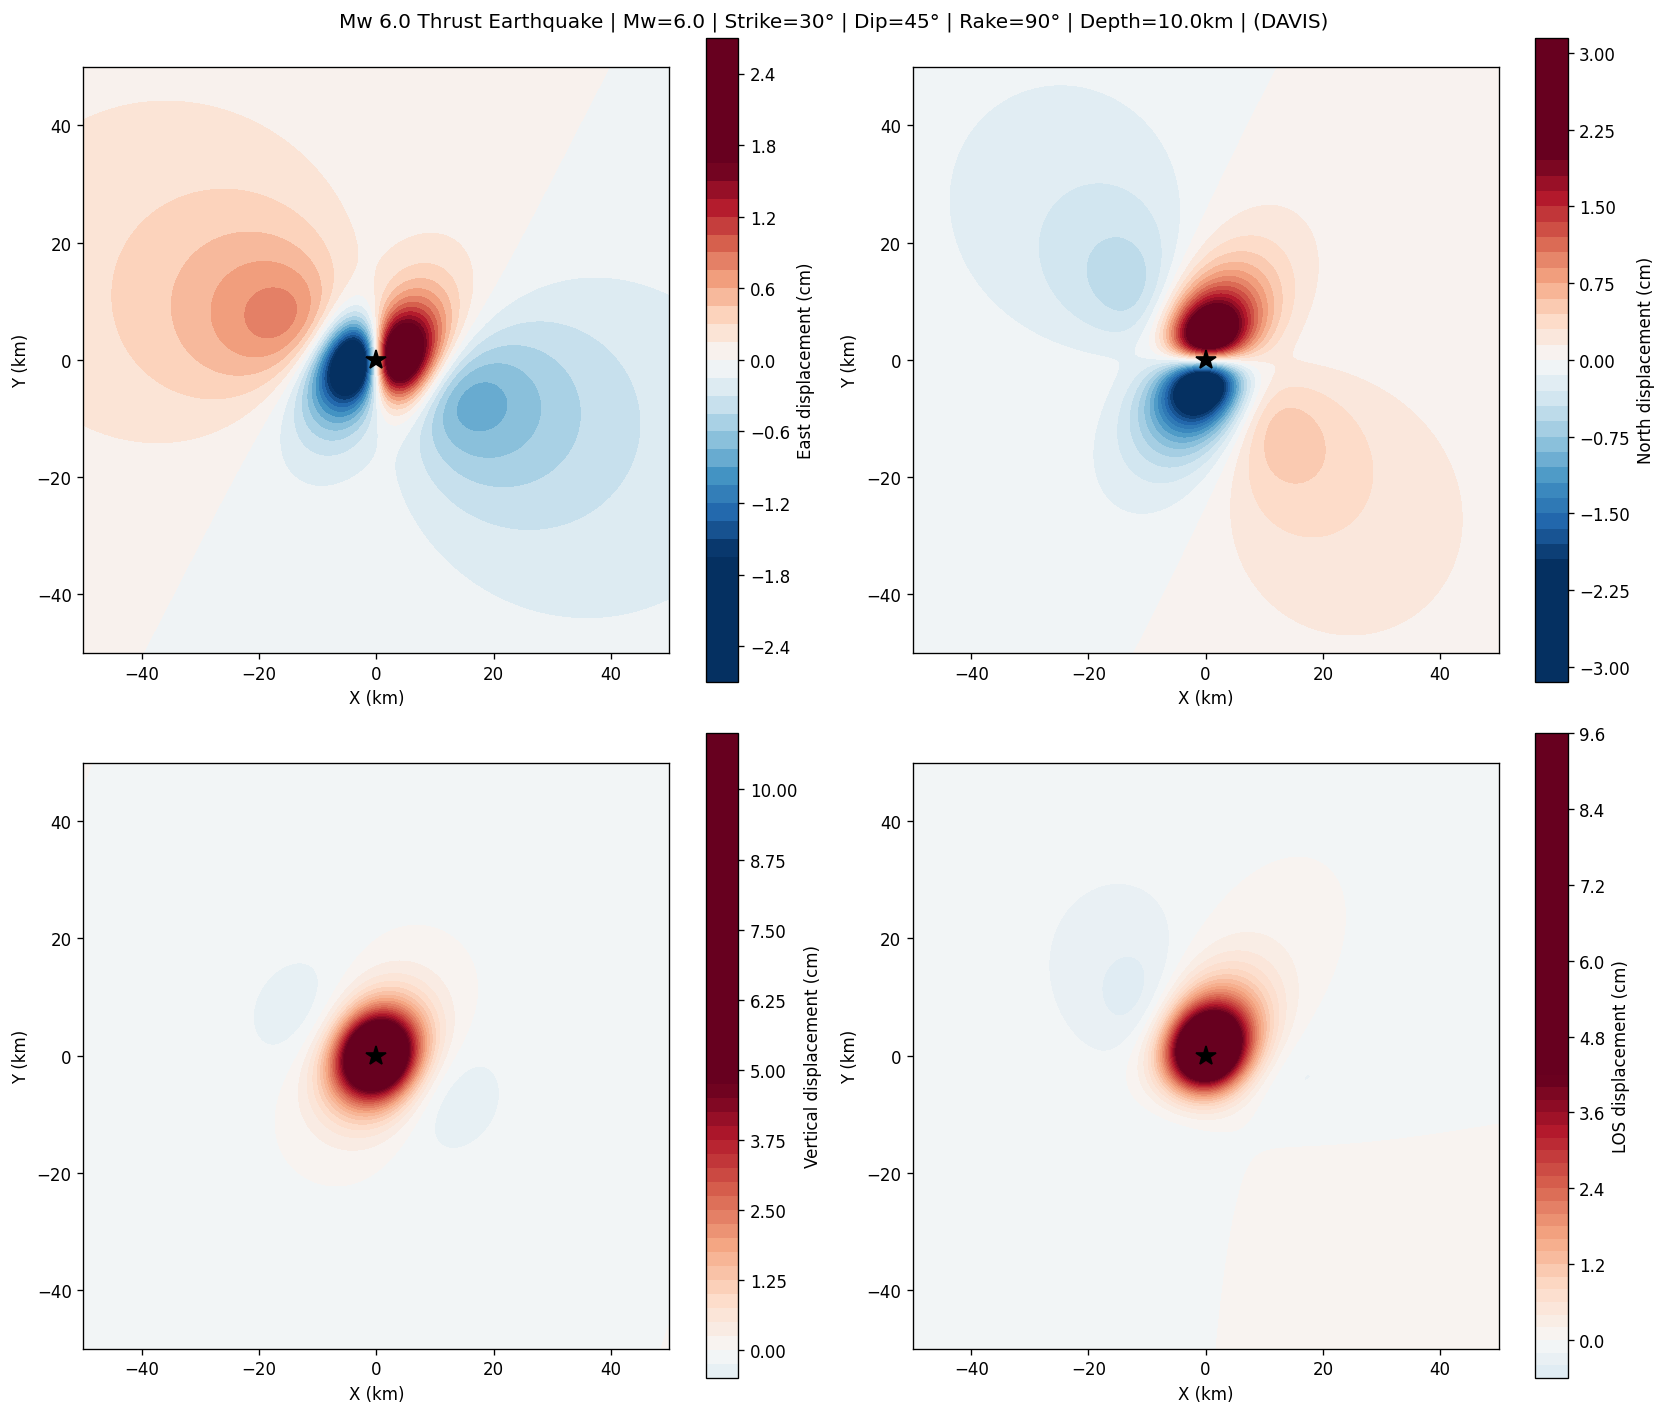

In [3]:
# Visualize displacement components
fig = plot_displacement_components(result, title_prefix="Mw 6.0 Thrust Earthquake")
plt.tight_layout()
plt.show()

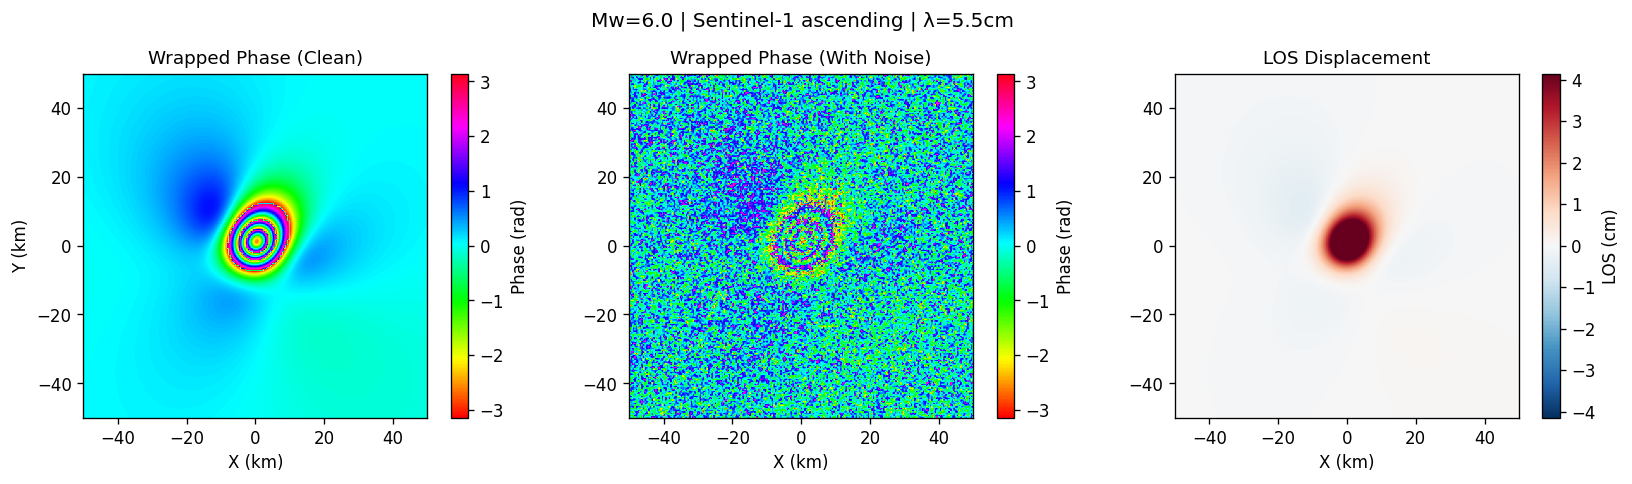

In [4]:
# Visualize InSAR products
fig = plot_insar_products(result, title_prefix="")
plt.tight_layout()
plt.show()

---

## 2. Fault Type Comparison

Compare deformation patterns for different fault types:
- **Thrust/Reverse** (rake = 90°): Compressional, one side moves up
- **Normal** (rake = -90°): Extensional, one side moves down  
- **Strike-slip** (rake = 0°): Lateral motion, characteristic four-lobed pattern

In [5]:
# Generate different fault types
fault_types = {
    'Thrust (rake=90°)': {'rake_deg': 90, 'dip_deg': 35},
    'Normal (rake=-90°)': {'rake_deg': -90, 'dip_deg': 60},
    'Strike-slip (rake=0°)': {'rake_deg': 0, 'dip_deg': 85},
}

results = {}
for name, params in fault_types.items():
    results[name] = generate_synthetic_insar(
        Mw=6.0,
        strike_deg=0,
        depth_km=10,
        satellite='sentinel1',
        add_noise=False,
        seed=42,
        **params
    )

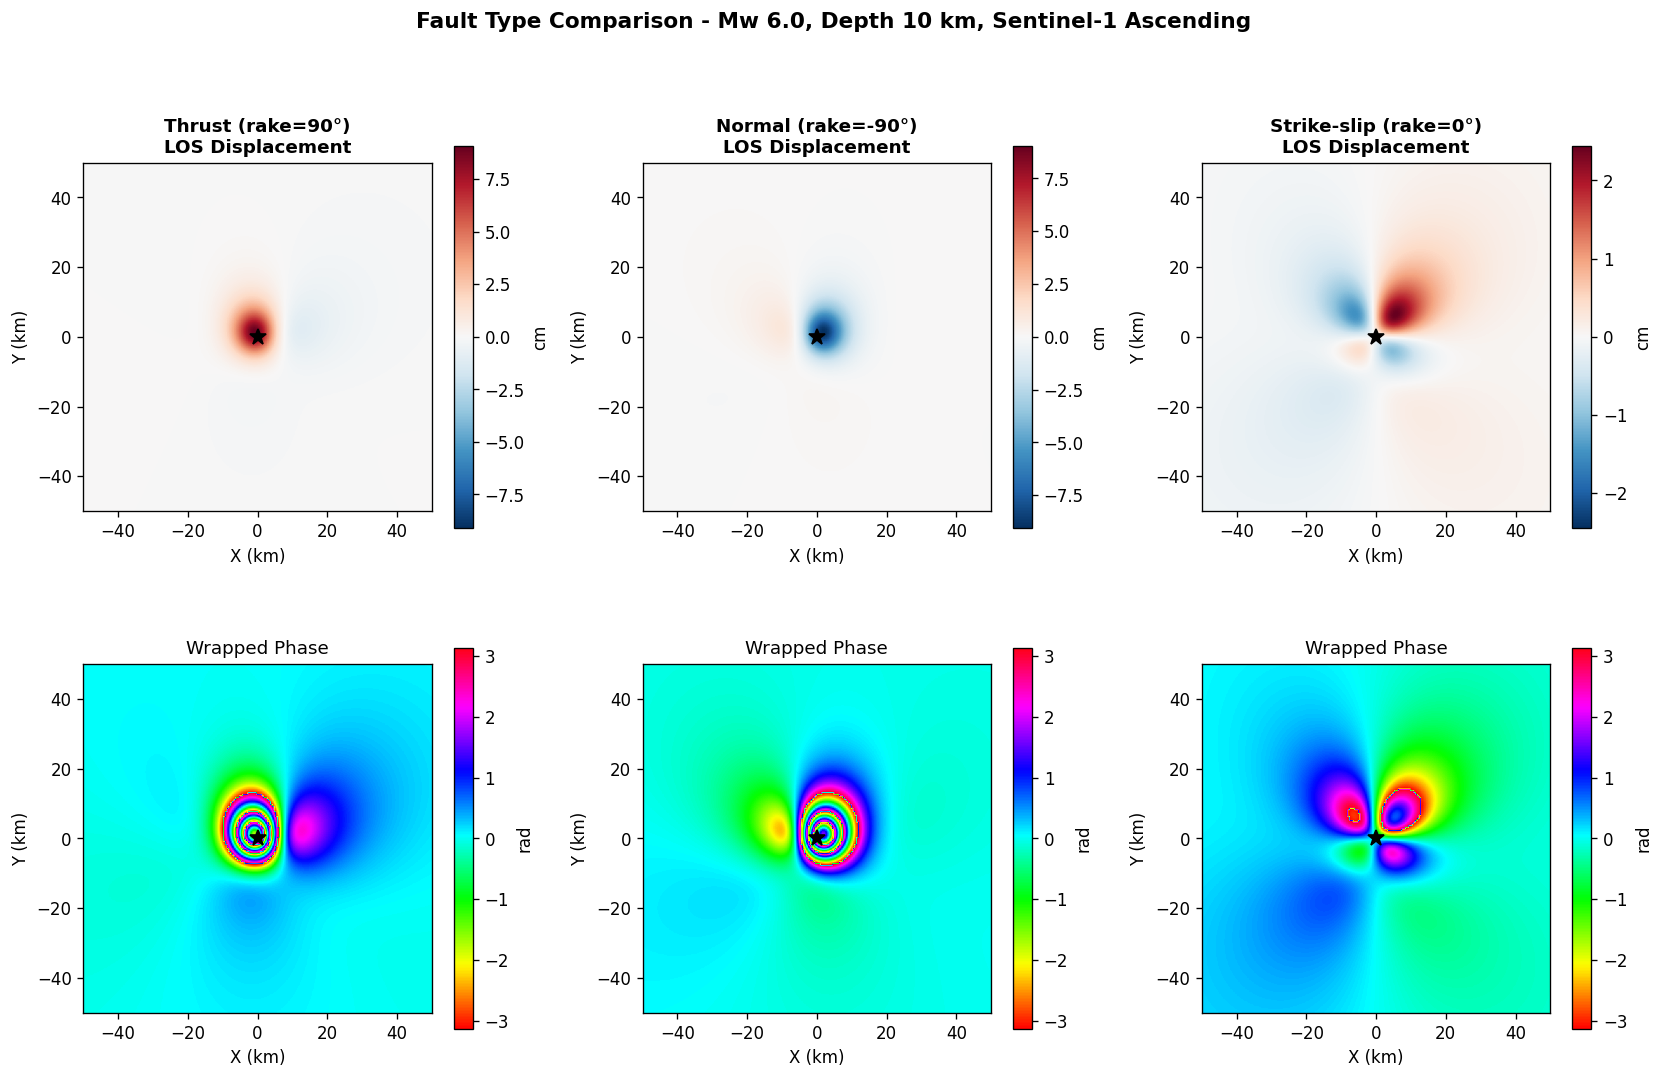

In [6]:
# Create comparison figure
fig, axes = plt.subplots(2, 3, figsize=(14, 9))

for idx, (name, result) in enumerate(results.items()):
    X = result['X_km']
    Y = result['Y_km']
    extent = [X.min(), X.max(), Y.min(), Y.max()]
    
    # LOS displacement
    los = result['los_displacement'] * 100  # cm
    vmax = max(np.abs(los).max(), 1)
    
    im1 = axes[0, idx].imshow(los, extent=extent, origin='lower', 
                               cmap='RdBu_r', vmin=-vmax, vmax=vmax)
    axes[0, idx].set_title(f'{name}\nLOS Displacement', fontweight='bold')
    axes[0, idx].set_xlabel('X (km)')
    axes[0, idx].set_ylabel('Y (km)')
    axes[0, idx].plot(0, 0, 'k*', markersize=10)
    plt.colorbar(im1, ax=axes[0, idx], label='cm', shrink=0.8)
    
    # Wrapped phase
    phase = result['phase_wrapped']
    im2 = axes[1, idx].imshow(phase, extent=extent, origin='lower',
                               cmap='hsv', vmin=-np.pi, vmax=np.pi)
    axes[1, idx].set_title('Wrapped Phase')
    axes[1, idx].set_xlabel('X (km)')
    axes[1, idx].set_ylabel('Y (km)')
    axes[1, idx].plot(0, 0, 'k*', markersize=10)
    plt.colorbar(im2, ax=axes[1, idx], label='rad', shrink=0.8)

fig.suptitle('Fault Type Comparison - Mw 6.0, Depth 10 km, Sentinel-1 Ascending', 
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---

## 3. Magnitude Scaling

Observe how surface displacement scales with earthquake magnitude.

In [7]:
# Generate interferograms for different magnitudes
magnitudes = [5.0, 5.5, 6.0, 6.5]
mag_results = {}

for mw in magnitudes:
    mag_results[mw] = generate_synthetic_insar(
        Mw=mw,
        strike_deg=45,
        dip_deg=45,
        rake_deg=90,
        depth_km=10,
        satellite='sentinel1',
        add_noise=False,
        seed=42
    )

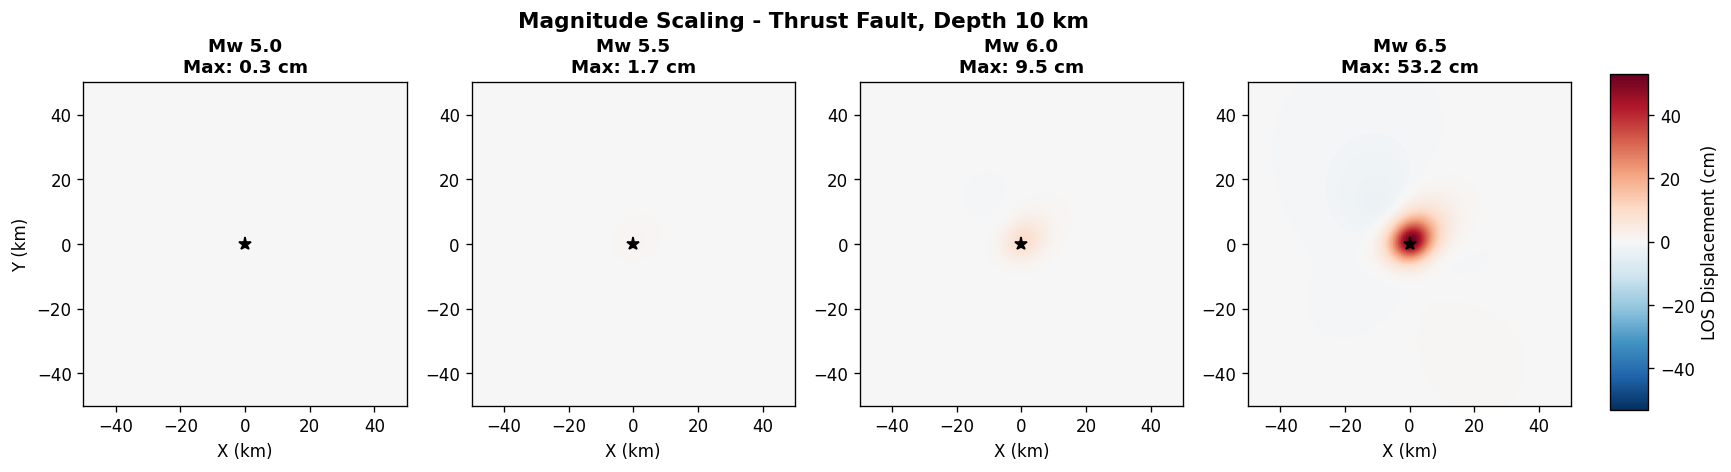

In [8]:
# Create magnitude comparison
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Use same color scale for all
global_max = max(np.abs(r['los_displacement']).max() for r in mag_results.values()) * 100

for idx, (mw, result) in enumerate(mag_results.items()):
    X = result['X_km']
    Y = result['Y_km']
    extent = [X.min(), X.max(), Y.min(), Y.max()]
    los = result['los_displacement'] * 100
    
    im = axes[idx].imshow(los, extent=extent, origin='lower',
                          cmap='RdBu_r', vmin=-global_max, vmax=global_max)
    axes[idx].set_title(f'Mw {mw}\nMax: {np.abs(los).max():.1f} cm', fontweight='bold')
    axes[idx].set_xlabel('X (km)')
    if idx == 0:
        axes[idx].set_ylabel('Y (km)')
    axes[idx].plot(0, 0, 'k*', markersize=8)

# Single colorbar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='LOS Displacement (cm)')

fig.suptitle('Magnitude Scaling - Thrust Fault, Depth 10 km', fontsize=13, fontweight='bold')
plt.show()

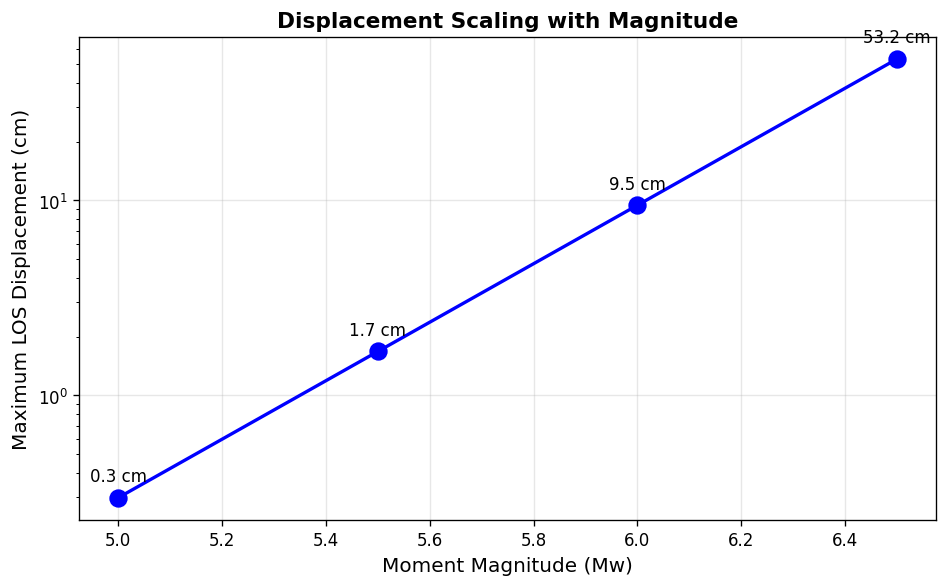

In [9]:
# Plot magnitude vs max displacement
mags = list(mag_results.keys())
max_disp = [np.abs(mag_results[m]['los_displacement']).max() * 100 for m in mags]

fig, ax = plt.subplots(figsize=(8, 5))
ax.semilogy(mags, max_disp, 'bo-', markersize=10, linewidth=2)
ax.set_xlabel('Moment Magnitude (Mw)', fontsize=12)
ax.set_ylabel('Maximum LOS Displacement (cm)', fontsize=12)
ax.set_title('Displacement Scaling with Magnitude', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add annotations
for m, d in zip(mags, max_disp):
    ax.annotate(f'{d:.1f} cm', (m, d), textcoords='offset points', 
                xytext=(0, 10), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

---

## 4. Satellite Comparison

Compare how different SAR satellites observe the same earthquake.

In [10]:
# List available satellites
satellites = list_satellites()
print("Available Satellites:")
print("=" * 60)
for key, sat in satellites.items():
    print(f"{key:12} | {sat.name:15} | {sat.band}-band | \u03bb={sat.wavelength_m*100:.1f} cm")

Available Satellites:
sentinel1    | Sentinel-1      | C-band | λ=5.5 cm
radarsat2    | RADARSAT-2      | C-band | λ=5.5 cm
envisat      | ENVISAT         | C-band | λ=5.6 cm
alos2        | ALOS-2          | L-band | λ=22.9 cm
nisar        | NISAR           | L-band | λ=23.8 cm
saocom       | SAOCOM          | L-band | λ=23.5 cm
terrasar     | TerraSAR-X      | X-band | λ=3.1 cm
cosmo        | COSMO-SkyMed    | X-band | λ=3.1 cm
iceye        | ICEYE           | X-band | λ=3.1 cm


In [11]:
# Compare C-band, L-band, and X-band
sat_compare = ['sentinel1', 'alos2', 'terrasar']
sat_results = {}

for sat in sat_compare:
    sat_results[sat] = generate_synthetic_insar(
        Mw=6.0,
        strike_deg=30,
        dip_deg=45,
        rake_deg=90,
        depth_km=10,
        satellite=sat,
        orbit='ascending',
        add_noise=False,
        seed=42
    )

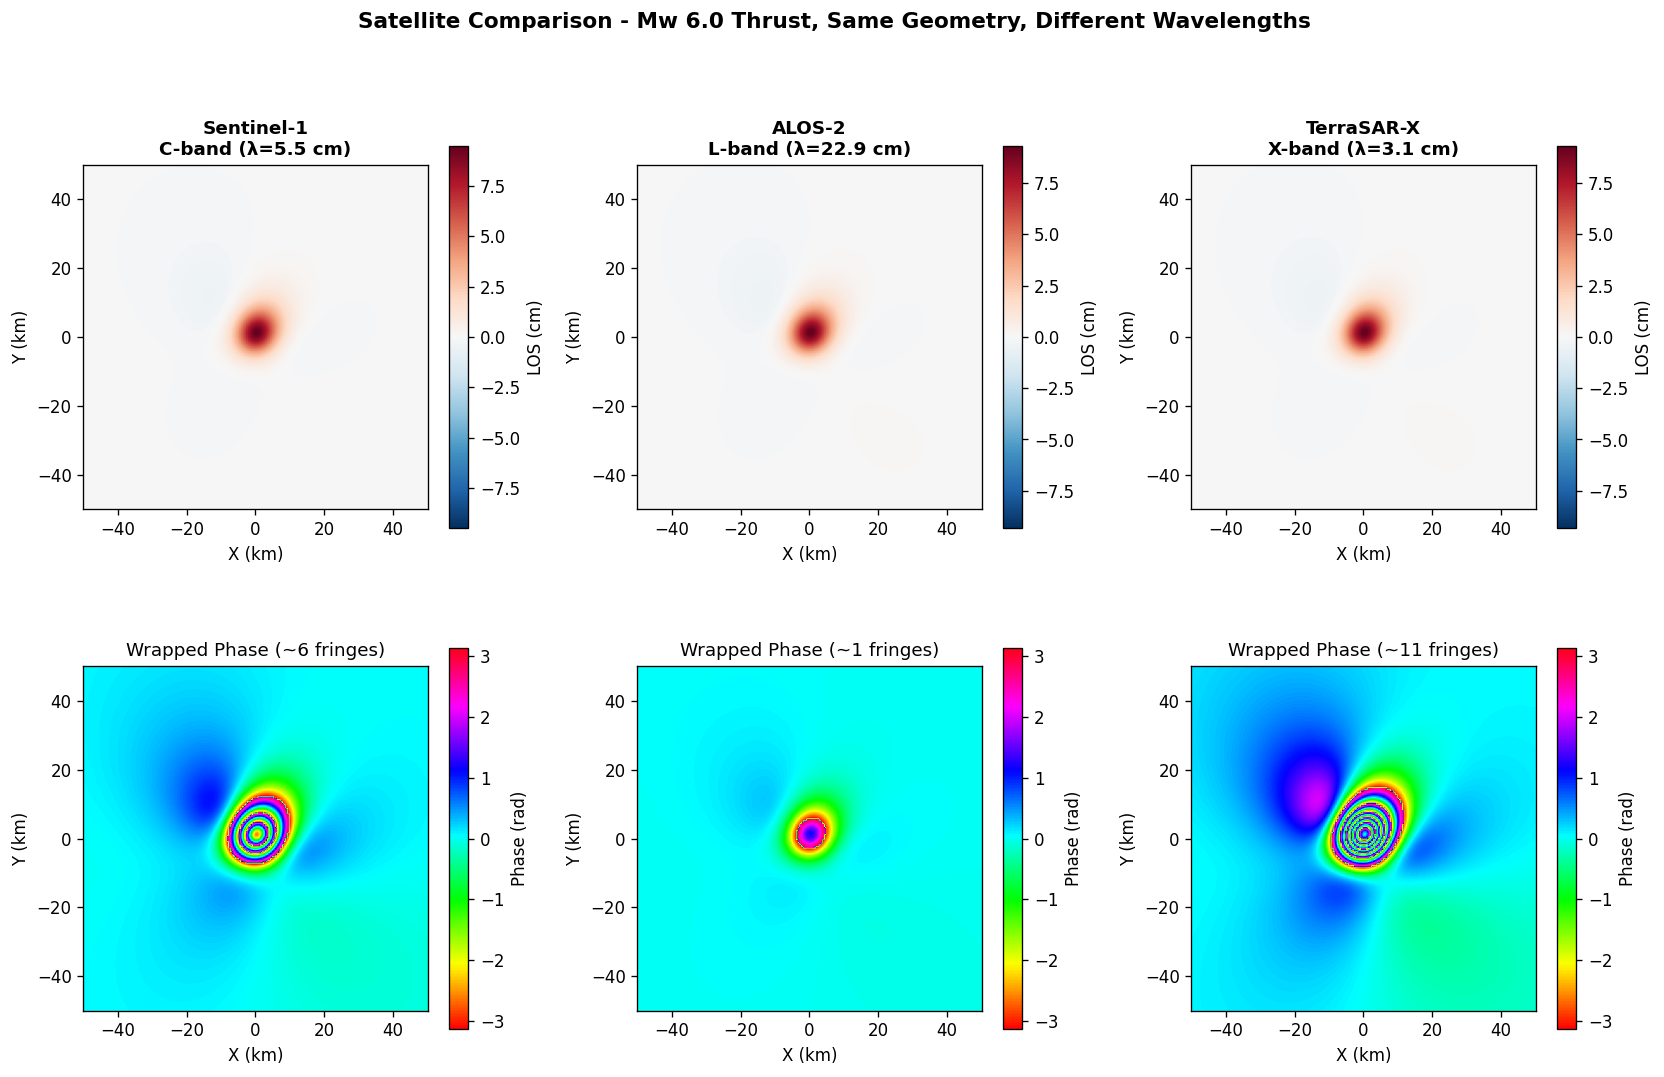


Note: Longer wavelength (L-band) = fewer fringes = easier to unwrap
      Shorter wavelength (X-band) = more fringes = higher sensitivity


In [12]:
# Create satellite comparison figure
fig, axes = plt.subplots(2, 3, figsize=(14, 9))

sat_info = {
    'sentinel1': ('Sentinel-1', 'C-band', 5.5),
    'alos2': ('ALOS-2', 'L-band', 22.9),
    'terrasar': ('TerraSAR-X', 'X-band', 3.1),
}

for idx, (sat, result) in enumerate(sat_results.items()):
    X = result['X_km']
    Y = result['Y_km']
    extent = [X.min(), X.max(), Y.min(), Y.max()]
    name, band, wl = sat_info[sat]
    
    # LOS displacement (same for all satellites)
    los = result['los_displacement'] * 100
    vmax = np.abs(los).max()
    
    im1 = axes[0, idx].imshow(los, extent=extent, origin='lower',
                               cmap='RdBu_r', vmin=-vmax, vmax=vmax)
    axes[0, idx].set_title(f'{name}\n{band} (\u03bb={wl} cm)', fontweight='bold')
    axes[0, idx].set_xlabel('X (km)')
    axes[0, idx].set_ylabel('Y (km)')
    plt.colorbar(im1, ax=axes[0, idx], label='LOS (cm)', shrink=0.8)
    
    # Wrapped phase (different fringe density)
    phase = result['phase_wrapped']
    im2 = axes[1, idx].imshow(phase, extent=extent, origin='lower',
                               cmap='hsv', vmin=-np.pi, vmax=np.pi)
    
    # Count fringes (approximation)
    n_fringes = int(np.abs(result['phase_unwrapped']).max() / np.pi)
    axes[1, idx].set_title(f'Wrapped Phase (~{n_fringes} fringes)')
    axes[1, idx].set_xlabel('X (km)')
    axes[1, idx].set_ylabel('Y (km)')
    plt.colorbar(im2, ax=axes[1, idx], label='Phase (rad)', shrink=0.8)

fig.suptitle('Satellite Comparison - Mw 6.0 Thrust, Same Geometry, Different Wavelengths',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nNote: Longer wavelength (L-band) = fewer fringes = easier to unwrap")
print("      Shorter wavelength (X-band) = more fringes = higher sensitivity")

---

## 5. Noise Effects

Visualize how random noise degrades the interferogram signal at different amplitudes.

In [13]:
# Generate with different noise amplitudes
noise_cases = {
    'No Noise': {'add_noise': False},
    'Low Noise (2 mm)': {'add_noise': True, 'noise_amplitude_m': 0.002},
    'Medium Noise (5 mm)': {'add_noise': True, 'noise_amplitude_m': 0.005},
    'High Noise (10 mm)': {'add_noise': True, 'noise_amplitude_m': 0.01},
}

noise_results = {}
for name, params in noise_cases.items():
    noise_results[name] = generate_synthetic_insar(
        Mw=6.0,
        strike_deg=45,
        dip_deg=45,
        rake_deg=90,
        depth_km=10,
        satellite='sentinel1',
        seed=42,
        **params
    )

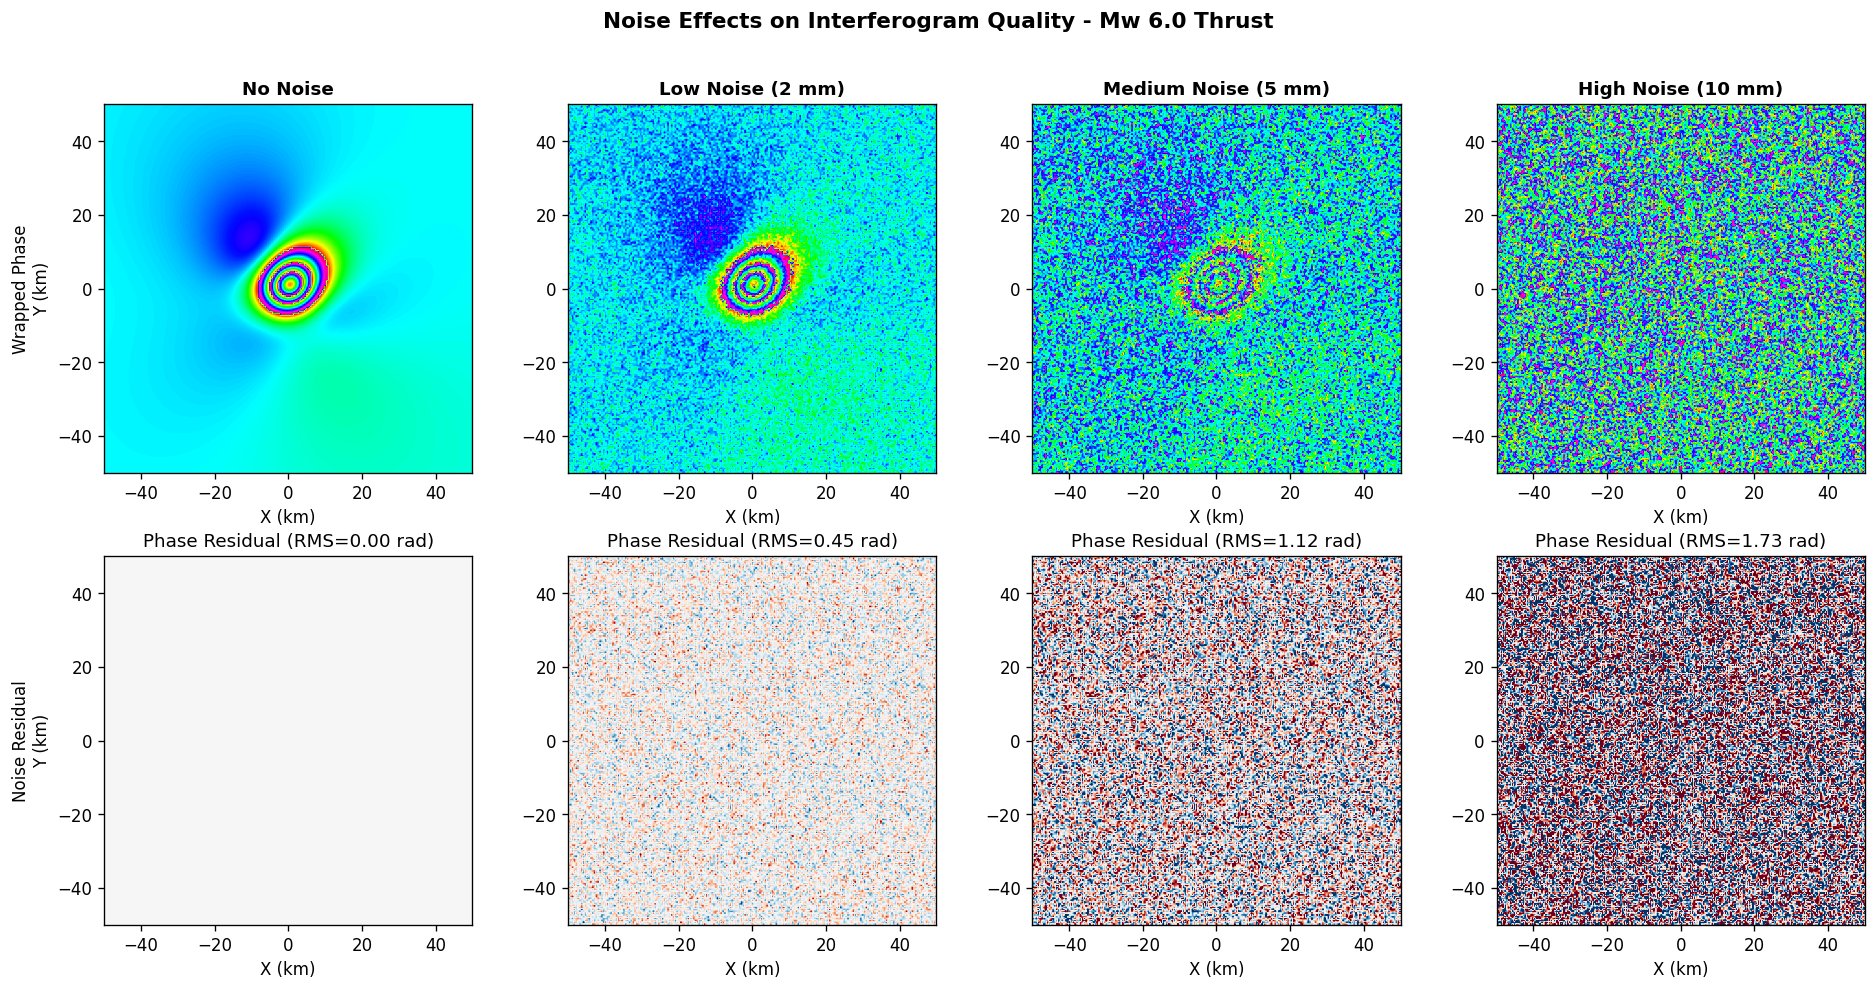

In [14]:
# Visualize noise effects on wrapped phase
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for idx, (name, result) in enumerate(noise_results.items()):
    X = result['X_km']
    Y = result['Y_km']
    extent = [X.min(), X.max(), Y.min(), Y.max()]
    
    # Wrapped phase (noisy)
    phase = result['phase_noisy']
    im1 = axes[0, idx].imshow(phase, extent=extent, origin='lower',
                               cmap='hsv', vmin=-np.pi, vmax=np.pi)
    axes[0, idx].set_title(f'{name}', fontweight='bold')
    axes[0, idx].set_xlabel('X (km)')
    if idx == 0:
        axes[0, idx].set_ylabel('Wrapped Phase\nY (km)')
    
    # Difference from clean signal (noise residual)
    clean_phase = noise_results['No Noise']['phase_wrapped']
    if name == 'No Noise':
        diff = np.zeros_like(clean_phase)
    else:
        diff = np.angle(np.exp(1j * (phase - clean_phase)))
    
    vmax_diff = 1.5  # fixed scale for comparison
    im2 = axes[1, idx].imshow(diff, extent=extent, origin='lower',
                               cmap='RdBu_r', vmin=-vmax_diff, vmax=vmax_diff)
    rms = np.std(diff)
    axes[1, idx].set_title(f'Phase Residual (RMS={rms:.2f} rad)')
    axes[1, idx].set_xlabel('X (km)')
    if idx == 0:
        axes[1, idx].set_ylabel('Noise Residual\nY (km)')

fig.suptitle('Noise Effects on Interferogram Quality - Mw 6.0 Thrust',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---

## 6. Time Series Generation

Generate a time series with pre-event, co-seismic, and post-event frames - ideal for ML training.

In [15]:
# Generate time series
ts_result = generate_timeseries(
    Mw=6.0,
    strike_deg=30,
    dip_deg=45,
    rake_deg=90,
    depth_km=10,
    satellite='sentinel1',
    n_pre=4,       # 4 pre-event frames
    n_event=1,     # 1 co-seismic frame
    n_post=4,      # 4 post-event frames
    seed=42
)

print(f"Time series shape: {ts_result['timeseries'].shape}")
print(f"Labels shape: {ts_result['labels'].shape}")
print(f"\nFrame structure:")
print(f"  - Pre-event frames: 0-3 (noise only)")
print(f"  - Event frame: 4 (earthquake signal + noise)")
print(f"  - Post-event frames: 5-8 (noise only)")

Time series shape: (9, 201, 201)
Labels shape: (9, 201, 201)

Frame structure:
  - Pre-event frames: 0-3 (noise only)
  - Event frame: 4 (earthquake signal + noise)
  - Post-event frames: 5-8 (noise only)


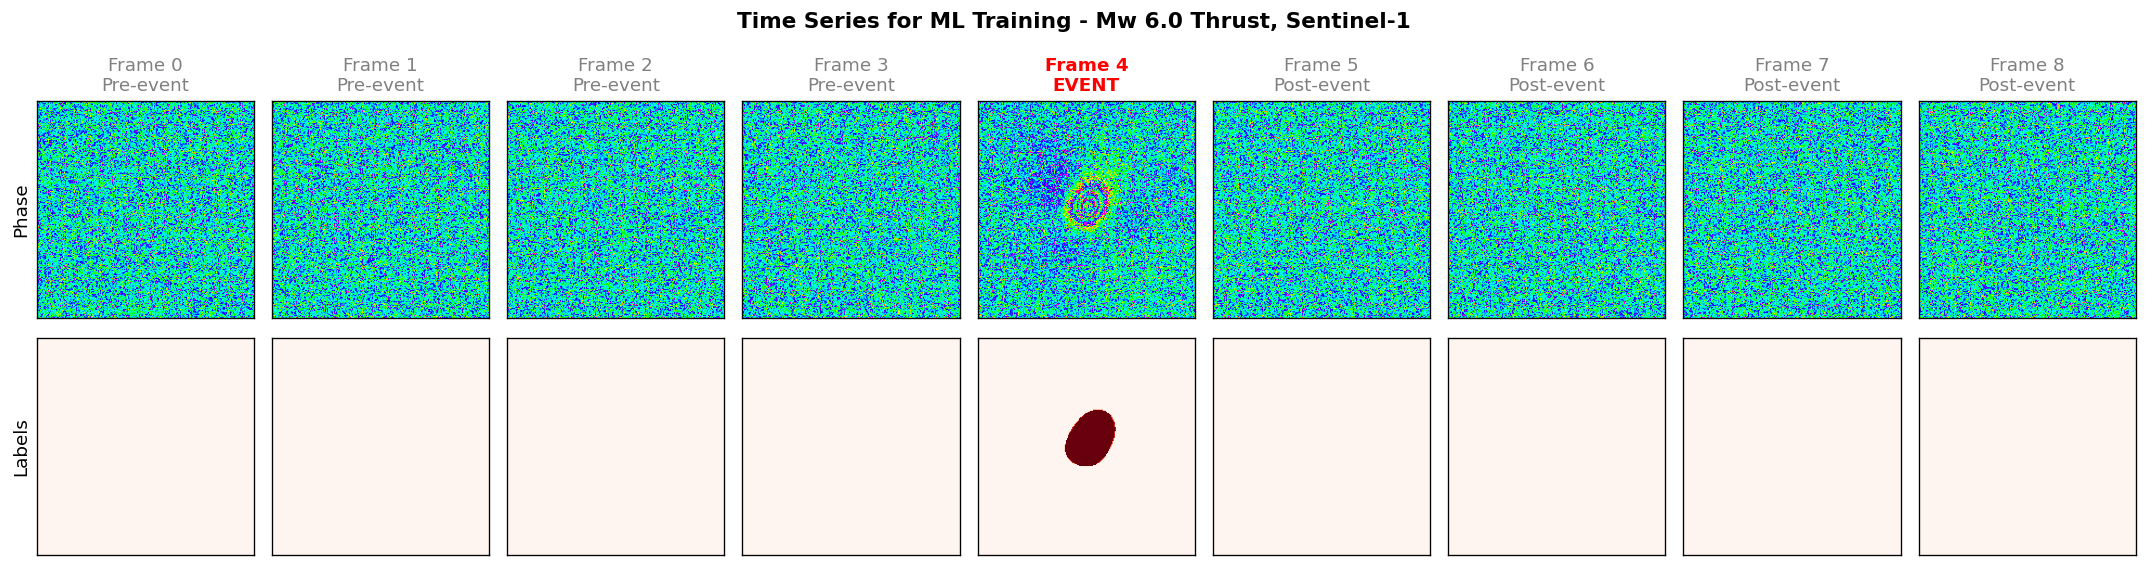

In [16]:
# Visualize time series
timeseries = ts_result['timeseries']
labels = ts_result['labels']
n_frames = timeseries.shape[0]

fig, axes = plt.subplots(2, n_frames, figsize=(18, 5))

X = ts_result['X_km']
Y = ts_result['Y_km']
extent = [X.min(), X.max(), Y.min(), Y.max()]

for t in range(n_frames):
    # Phase
    axes[0, t].imshow(timeseries[t], extent=extent, origin='lower',
                      cmap='hsv', vmin=-np.pi, vmax=np.pi)
    
    # Frame type label
    if t < 4:
        frame_type = 'Pre-event'
        color = 'gray'
    elif t == 4:
        frame_type = 'EVENT'
        color = 'red'
    else:
        frame_type = 'Post-event'
        color = 'gray'
    
    axes[0, t].set_title(f'Frame {t}\n{frame_type}', color=color, fontweight='bold' if t==4 else 'normal')
    axes[0, t].set_xticks([])
    axes[0, t].set_yticks([])
    
    # Labels (segmentation mask)
    axes[1, t].imshow(labels[t], extent=extent, origin='lower',
                      cmap='Reds', vmin=0, vmax=1)
    axes[1, t].set_xticks([])
    axes[1, t].set_yticks([])

axes[0, 0].set_ylabel('Phase', fontsize=11)
axes[1, 0].set_ylabel('Labels', fontsize=11)

fig.suptitle('Time Series for ML Training - Mw 6.0 Thrust, Sentinel-1',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

---

## 7. Batch Generation for ML Training

Generate multiple samples with randomized parameters for training machine learning models.

In [17]:
# Generate a small batch
batch = generate_training_batch(
    n_samples=12,
    mw_range=(5.0, 6.5),
    depth_range_km=(5, 20),
    satellite='sentinel1',
    n_pre=2,
    n_event=1,
    n_post=2,
    seed=42,
    verbose=False
)

print(f"Generated {len(batch)} samples")
print(f"\nSample parameters:")
for i, sample in enumerate(batch[:4]):
    meta = sample['metadata']
    print(f"  Sample {i}: Mw={meta['Mw']:.1f}, depth={meta['depth_km']:.1f} km, "
          f"strike={meta['strike_deg']:.0f}\u00b0, dip={meta['dip_deg']:.0f}\u00b0, rake={meta['rake_deg']:.0f}\u00b0")

Generated 12 samples

Sample parameters:
  Sample 0: Mw=5.6, depth=14.0 km, strike=56°, dip=47°, rake=-92°
  Sample 1: Mw=5.2, depth=8.6 km, strike=118°, dip=62°, rake=-88°
  Sample 2: Mw=6.3, depth=10.4 km, strike=129°, dip=51°, rake=-79°
  Sample 3: Mw=6.5, depth=6.2 km, strike=160°, dip=32°, rake=103°


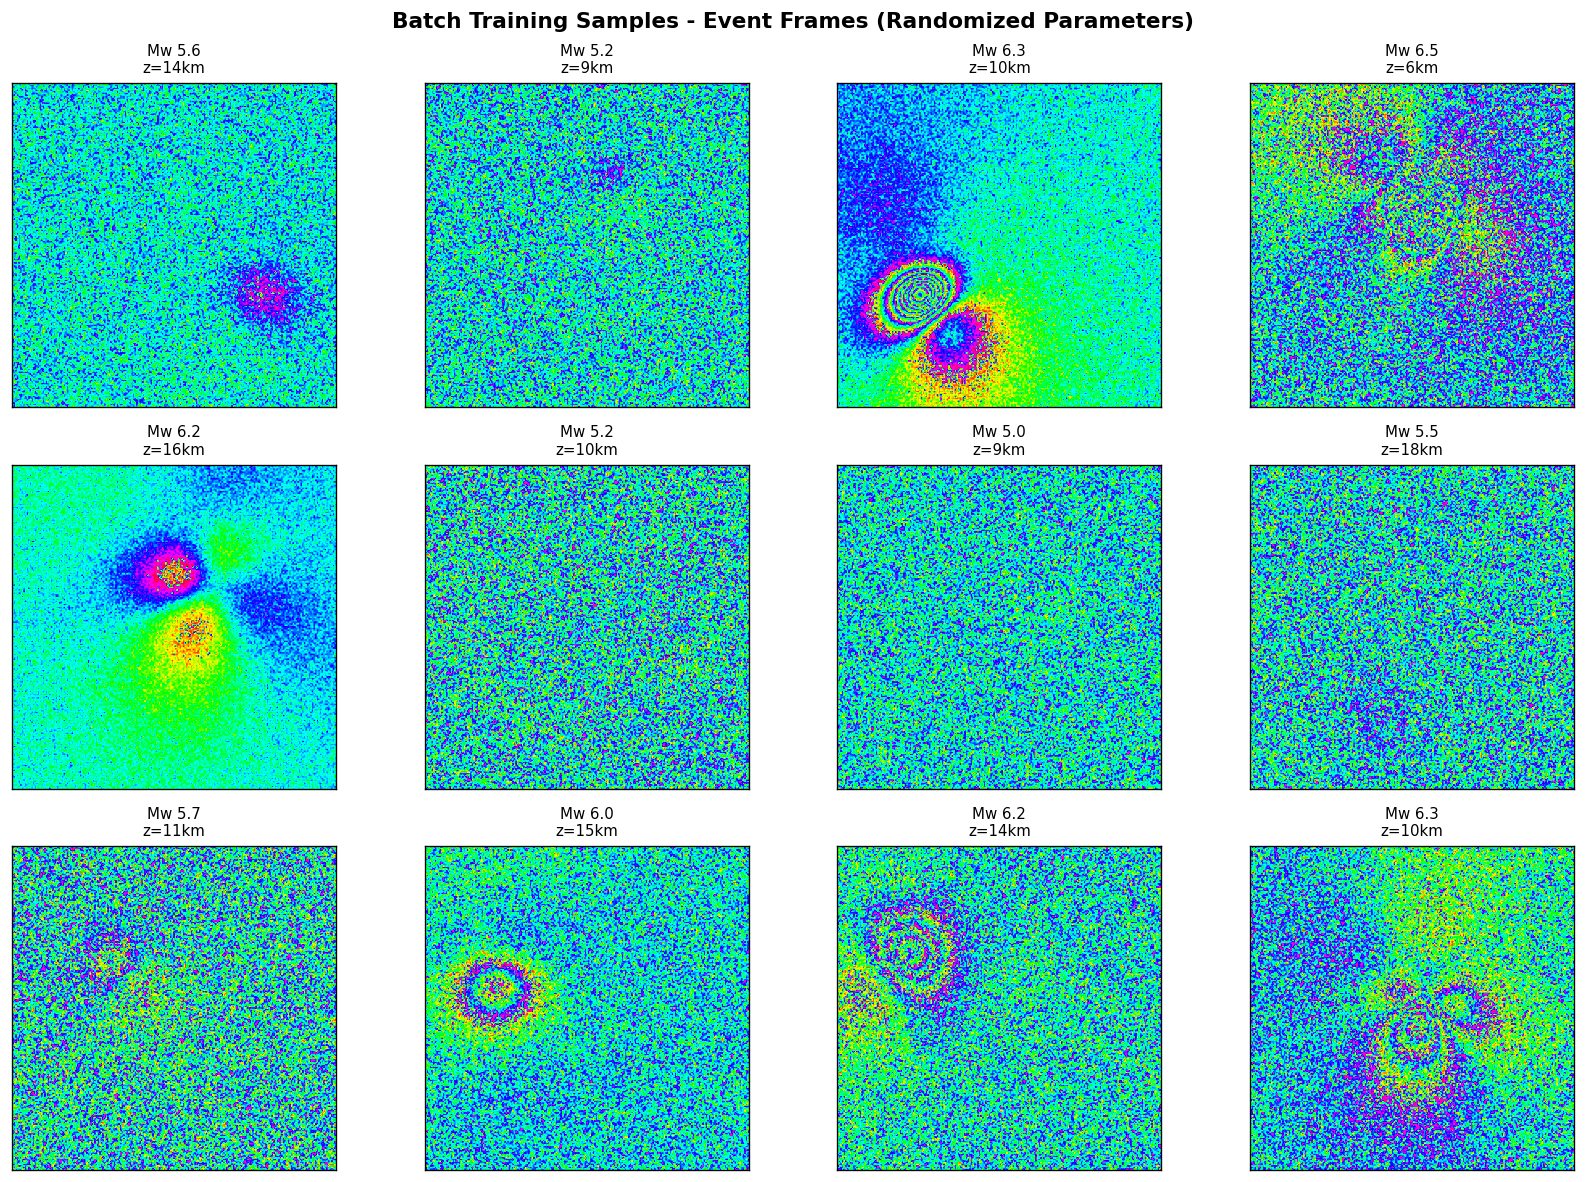

In [18]:
# Visualize batch samples (event frame only)
fig, axes = plt.subplots(3, 4, figsize=(14, 10))

for idx, sample in enumerate(batch):
    ax = axes[idx // 4, idx % 4]
    
    # Get event frame (index 2 with n_pre=2)
    event_frame = sample['timeseries'][2]
    meta = sample['metadata']
    
    ax.imshow(event_frame, cmap='hsv', vmin=-np.pi, vmax=np.pi)
    ax.set_title(f"Mw {meta['Mw']:.1f}\nz={meta['depth_km']:.0f}km", fontsize=9)
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle('Batch Training Samples - Event Frames (Randomized Parameters)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

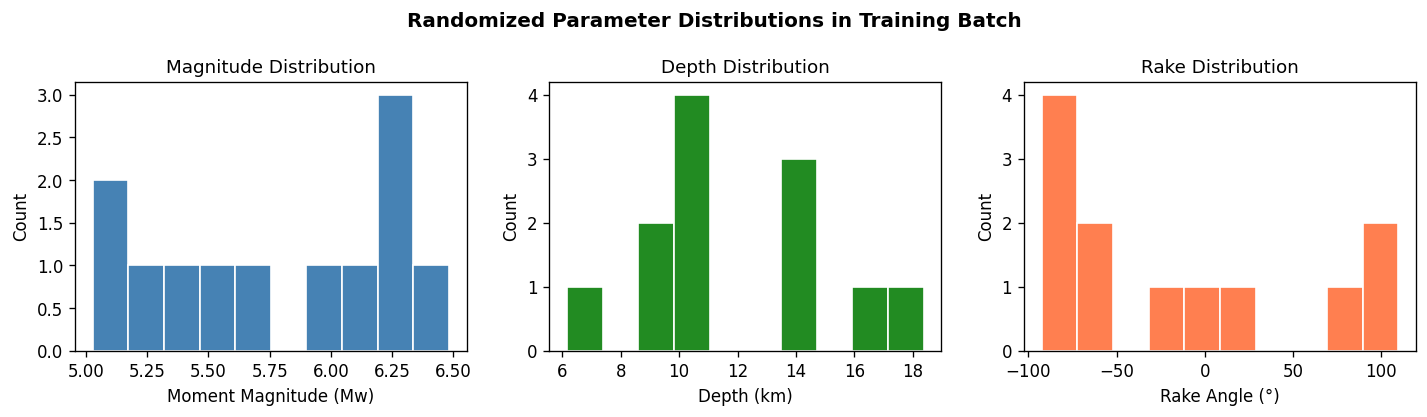

In [19]:
# Show parameter distribution
mws = [s['metadata']['Mw'] for s in batch]
depths = [s['metadata']['depth_km'] for s in batch]
rakes = [s['metadata']['rake_deg'] for s in batch]

fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))

axes[0].hist(mws, bins=10, color='steelblue', edgecolor='white')
axes[0].set_xlabel('Moment Magnitude (Mw)')
axes[0].set_ylabel('Count')
axes[0].set_title('Magnitude Distribution')

axes[1].hist(depths, bins=10, color='forestgreen', edgecolor='white')
axes[1].set_xlabel('Depth (km)')
axes[1].set_ylabel('Count')
axes[1].set_title('Depth Distribution')

axes[2].hist(rakes, bins=10, color='coral', edgecolor='white')
axes[2].set_xlabel('Rake Angle (\u00b0)')
axes[2].set_ylabel('Count')
axes[2].set_title('Rake Distribution')

plt.suptitle('Randomized Parameter Distributions in Training Batch',
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

---

## 8. Publication-Quality Figure

Create a comprehensive figure suitable for publications.

In [20]:
# Generate high-quality result
pub_result = generate_synthetic_insar(
    Mw=6.2,
    strike_deg=35,
    dip_deg=40,
    rake_deg=85,
    depth_km=12,
    grid_extent_km=60,
    grid_spacing_km=0.3,
    satellite='sentinel1',
    orbit='ascending',
    add_noise=True,
    noise_amplitude_m=0.003,  # 3 mm - subtle noise
    seed=123
)

/tmp/ipykernel_1094244/2867713480.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


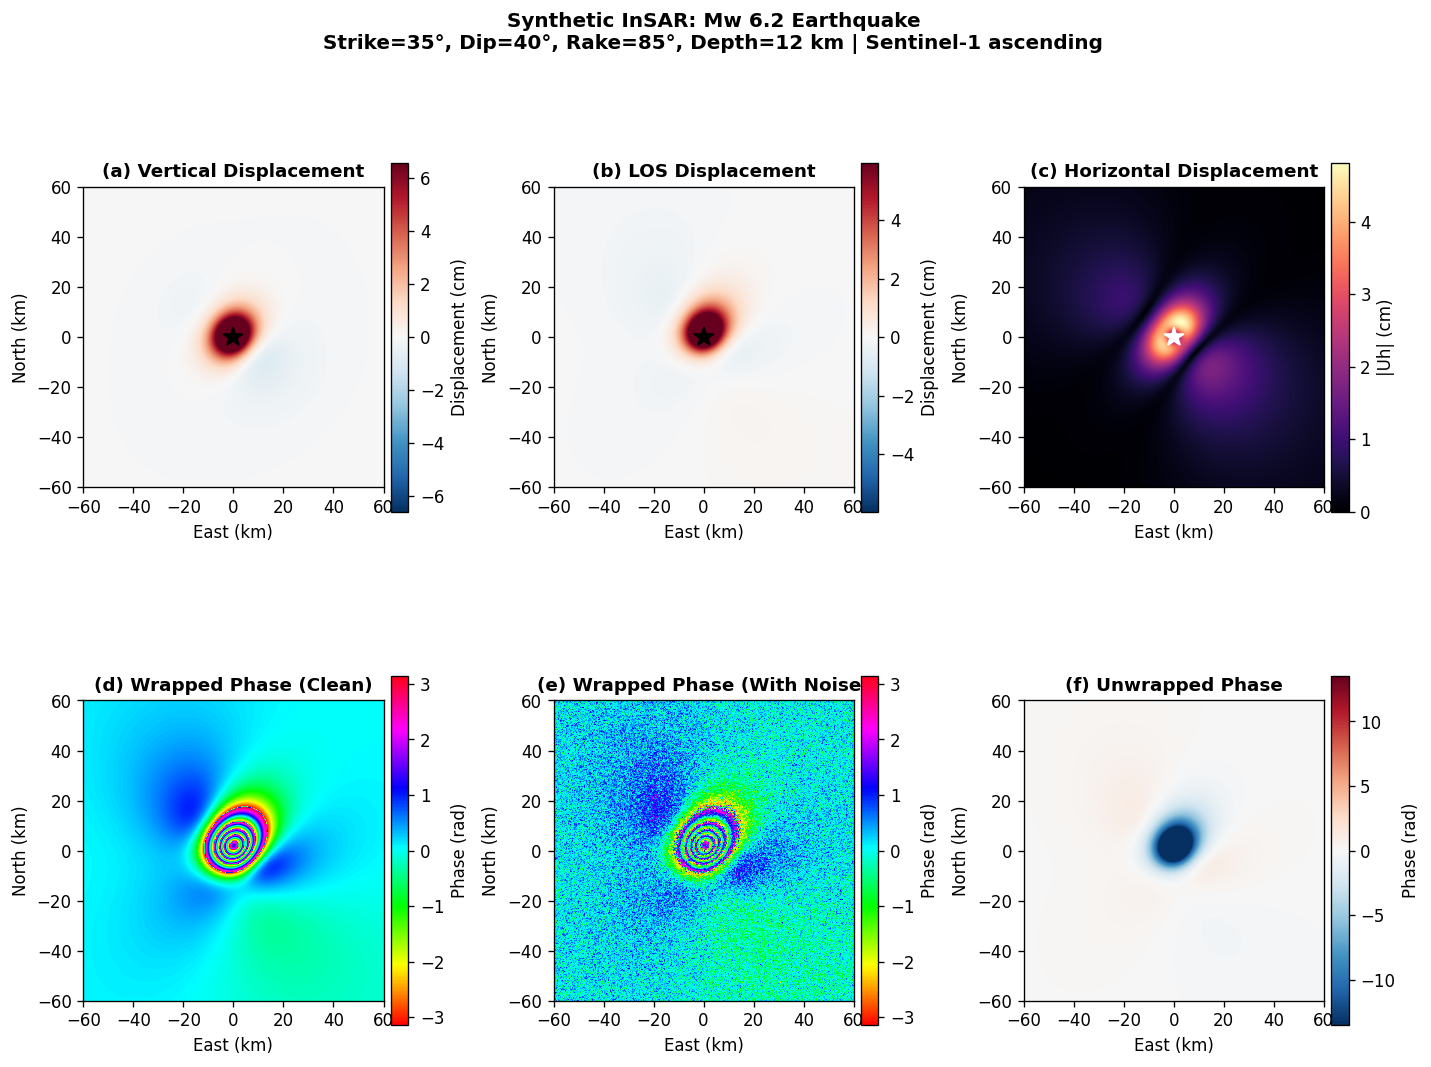


Figure saved as 'synthetic_insar_example.png'


In [21]:
# Create publication figure
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.25, wspace=0.3)

X = pub_result['X_km']
Y = pub_result['Y_km']
extent = [X.min(), X.max(), Y.min(), Y.max()]
meta = pub_result['metadata']

def add_colorbar(im, ax, label):
    cbar = plt.colorbar(im, ax=ax, shrink=0.85, pad=0.02)
    cbar.set_label(label, fontsize=10)
    return cbar

# (a) Vertical displacement
ax1 = fig.add_subplot(gs[0, 0])
uz = pub_result['Uz'] * 100
vmax_uz = np.percentile(np.abs(uz), 99)
im1 = ax1.imshow(uz, extent=extent, origin='lower', cmap='RdBu_r', vmin=-vmax_uz, vmax=vmax_uz)
ax1.set_title('(a) Vertical Displacement', fontweight='bold')
ax1.set_xlabel('East (km)')
ax1.set_ylabel('North (km)')
ax1.plot(meta['xcen_km'], meta['ycen_km'], 'k*', markersize=12, label='Epicenter')
add_colorbar(im1, ax1, 'Displacement (cm)')

# (b) LOS displacement
ax2 = fig.add_subplot(gs[0, 1])
los = pub_result['los_displacement'] * 100
vmax_los = np.percentile(np.abs(los), 99)
im2 = ax2.imshow(los, extent=extent, origin='lower', cmap='RdBu_r', vmin=-vmax_los, vmax=vmax_los)
ax2.set_title('(b) LOS Displacement', fontweight='bold')
ax2.set_xlabel('East (km)')
ax2.set_ylabel('North (km)')
ax2.plot(meta['xcen_km'], meta['ycen_km'], 'k*', markersize=12)
add_colorbar(im2, ax2, 'Displacement (cm)')

# (c) Horizontal displacement magnitude
ax3 = fig.add_subplot(gs[0, 2])
uh = np.sqrt(pub_result['Ue']**2 + pub_result['Un']**2) * 100
im3 = ax3.imshow(uh, extent=extent, origin='lower', cmap='magma', vmin=0)
ax3.set_title('(c) Horizontal Displacement', fontweight='bold')
ax3.set_xlabel('East (km)')
ax3.set_ylabel('North (km)')
ax3.plot(meta['xcen_km'], meta['ycen_km'], 'w*', markersize=12)
add_colorbar(im3, ax3, '|Uh| (cm)')

# (d) Wrapped phase (clean)
ax4 = fig.add_subplot(gs[1, 0])
im4 = ax4.imshow(pub_result['phase_wrapped'], extent=extent, origin='lower', 
                  cmap='hsv', vmin=-np.pi, vmax=np.pi)
ax4.set_title('(d) Wrapped Phase (Clean)', fontweight='bold')
ax4.set_xlabel('East (km)')
ax4.set_ylabel('North (km)')
add_colorbar(im4, ax4, 'Phase (rad)')

# (e) Wrapped phase (noisy)
ax5 = fig.add_subplot(gs[1, 1])
im5 = ax5.imshow(pub_result['phase_noisy'], extent=extent, origin='lower',
                  cmap='hsv', vmin=-np.pi, vmax=np.pi)
ax5.set_title('(e) Wrapped Phase (With Noise)', fontweight='bold')
ax5.set_xlabel('East (km)')
ax5.set_ylabel('North (km)')
add_colorbar(im5, ax5, 'Phase (rad)')

# (f) Unwrapped phase
ax6 = fig.add_subplot(gs[1, 2])
unwrapped = pub_result['phase_unwrapped']
vmax_uw = np.percentile(np.abs(unwrapped), 99)
im6 = ax6.imshow(unwrapped, extent=extent, origin='lower', cmap='RdBu_r', vmin=-vmax_uw, vmax=vmax_uw)
ax6.set_title('(f) Unwrapped Phase', fontweight='bold')
ax6.set_xlabel('East (km)')
ax6.set_ylabel('North (km)')
add_colorbar(im6, ax6, 'Phase (rad)')

# Main title with earthquake parameters
title = (f"Synthetic InSAR: Mw {meta['Mw']:.1f} Earthquake\n"
         f"Strike={meta['strike_deg']:.0f}\u00b0, Dip={meta['dip_deg']:.0f}\u00b0, "
         f"Rake={meta['rake_deg']:.0f}\u00b0, Depth={meta['depth_km']:.0f} km | "
         f"{meta['satellite']} {meta['orbit']}")
fig.suptitle(title, fontsize=12, fontweight='bold', y=0.98)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('synthetic_insar_example.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\nFigure saved as 'synthetic_insar_example.png'")

---

## Summary

EQ-INSAR provides a lightweight toolkit for generating synthetic InSAR earthquake data:

| Feature | Function |
|---------|----------|
| Single interferogram | `generate_synthetic_insar()` |
| Time series | `generate_timeseries()` |
| Batch generation | `generate_training_batch()` |
| Visualization | `plot_displacement_components()`, `plot_insar_products()` |

### Key Capabilities:
- **9 satellite configurations** with accurate geometries
- **Simple noise model** (random Gaussian + orbital ramps)
- **ML-ready outputs** with binary segmentation labels
- **Fast computation** using Davis (1986) point source model
- **Minimal dependencies** (numpy only for core)
- **Reproducible results** with seed control

---

*EQ-INSAR: Earthquake InSAR Synthetic Data Generator (Lite)*  
*MIT License*